In [100]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd


In [20]:
kick_signal, kick_sr = librosa.load('./drums/kicks/kick (1).wav', mono=True, sr=44100)
snare_signal, snare_sr = librosa.load('./drums/snares/snare (1).wav', mono=True, sr=44100)
hh_signal, hh_sr = librosa.load('./drums/hihats/hihat (1).wav', mono=True, sr=44100)

print(kick_signal.shape, kick_sr)
print(snare_signal.shape, snare_sr)
print(hh_signal.shape, hh_sr)


(8519,) 44100
(17521,) 44100
(7402,) 44100


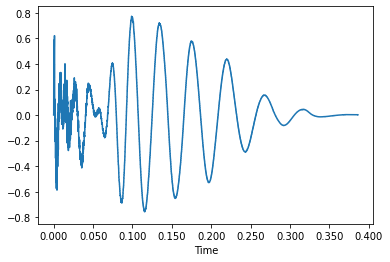

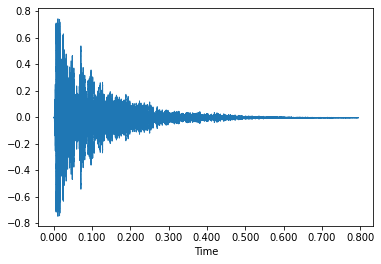

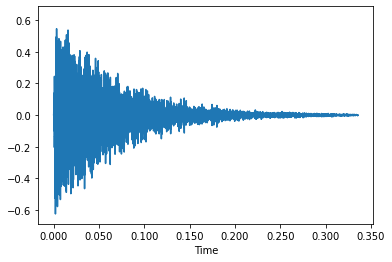

In [10]:
def plot_waveform(signal, sr):
    librosa.display.waveshow(signal)
    plt.show()

plot_waveform(kick_signal, kick_sr)
plot_waveform(snare_signal, snare_sr)
plot_waveform(hh_signal, hh_sr)

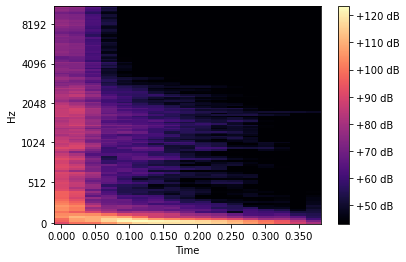

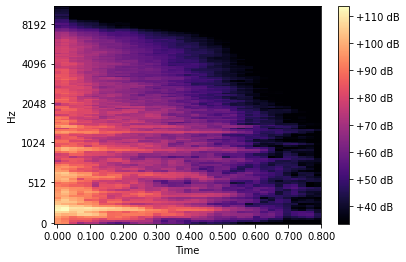

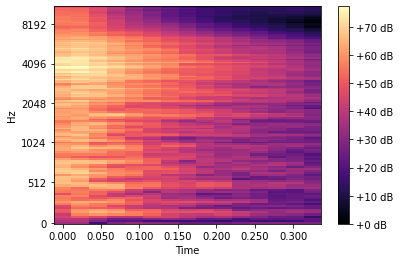

In [71]:
def plot_spectrogram(signal, sr):
    stft = librosa.stft(signal)
    stft_magnitude, _ = librosa.magphase(stft)

    mel_spectro = librosa.feature.melspectrogram(S=stft_magnitude, sr=sr)
    db_mel_spectro = librosa.amplitude_to_db(mel_spectro, ref=np.min)
    
    librosa.display.specshow(db_mel_spectro, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.0f dB")
    plt.show()

plot_spectrogram(kick_signal, kick_sr)
plot_spectrogram(snare_signal, snare_sr)
plot_spectrogram(hh_signal, hh_sr)

In [59]:
def preprocess_signal(signal, max_ms):
    max_len = (44100 // 1000) * max_ms
    signal_len = len(signal)

    if signal_len > max_len:
        signal = signal[:max_len]
    else:
        pad_len = max_len - signal_len
        zeros = np.zeros(pad_len)
        signal = [*signal, *zeros]

    return np.array(signal)


proc_kick = preprocess_signal(kick_signal, 200)
proc_snare = preprocess_signal(snare_signal, 200)
proc_hh = preprocess_signal(hh_signal, 200)

In [116]:
def extract_features(signal, sr):
    zero_crossings = sum(librosa.zero_crossings(signal, pad=False))
    
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_rollof = librosa.feature.spectral_rolloff(y=signal, sr=sr)[0]

    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=12)
    mfccs_mean = np.mean(mfccs, axis=1)

    features = np.hstack((zero_crossings, spectral_centroid, spectral_rollof, mfccs_mean))
    return np.array(features)


# extract_features(proc_kick, kick_sr)
# extract_features(proc_snare, snare_sr)
# extract_features(proc_hh, hh_sr)

In [97]:
def load_data():
    X = []
    y = []

    for file in glob.glob('./drums/*/*.wav'):
        filename = os.path.basename(file)
        
        label = filename.split()[0]
        signal, sr = librosa.load(file, mono=True, sr=44100)
        processed_sig = preprocess_signal(signal, 200)
        features = extract_features(processed_sig, sr)
        
        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

X, y = load_data()

In [99]:
print(X.shape)
print(y.shape)

(420, 49)
(420,)


In [121]:
col_names = columns=[f'feature {i}' for i in range(49)]
col_names.append('y')

merged_lists = np.hstack((X, y.reshape(-1, 1)))
data = pd.DataFrame(merged_lists, columns=col_names)

In [122]:
data.head()

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 40,feature 41,feature 42,feature 43,feature 44,feature 45,feature 46,feature 47,feature 48,y
0,2182.0,8081.51986885905,7818.9869758520335,7493.835206280108,7136.180435874208,7064.151944188787,7014.852985239259,6857.2442204745275,6736.553442189596,6567.836176821205,...,40.83321455029712,-35.646395916919666,4.487592797076391,-10.72258908582974,-7.370422078707975,2.206597901397981,-3.519298101842376,3.762890335579157,-4.223091953057297,hihat
1,3023.0,8137.9789045356465,8621.103706501533,9273.438664431598,9260.802355688844,9304.890428995353,9203.829693863081,9075.394636947061,8868.31768932561,8744.004920451429,...,61.77317810058594,-5.477348327636719,29.447378158569336,-0.5582584738731384,10.262467384338379,-9.73954963684082,-2.0871849060058594,-1.8547409772872925,0.19140373170375824,hihat
2,962.0,5278.903801543048,5216.853403141086,5391.106004063709,5034.656116617431,4635.644740028836,4188.90004885735,3571.2635269390194,3220.108353672353,3004.1851791726494,...,26.022247314453125,-14.258333206176758,11.193263053894043,-14.955642700195312,-1.6021112203598022,0.5242987275123596,-10.002911567687988,-5.422336101531982,-1.8770222663879395,hihat
3,1660.0,5983.958639339617,6211.375150688878,6326.857367423769,6279.660838395323,6086.392413680718,5715.782022137685,5099.075253752681,4747.306954586127,4533.876679911449,...,25.589622497558594,-37.439300537109375,-8.078697204589844,-27.473838806152344,0.2694859206676483,-5.813527584075928,-17.20060157775879,-13.231274604797363,-1.0771127939224243,hihat
4,1058.0,4657.017167044664,4554.648136715473,4596.571231483818,4761.253330563248,4782.49615853906,4644.734273301345,4325.254955865741,4244.289758156719,3981.7979897520745,...,24.169683051005247,-23.35242161906722,2.962119754510918,-26.444581204662725,-11.14844625335849,-12.682475590643438,-4.60899961935988,-9.65827446312897,-1.0437824874661605,hihat


In [123]:
data.to_csv('extracted_features.csv', index=False)